## Умова

### Мета роботи

Мета роботи:
* Створити багатошарову нейронну мережу прямого розповсюдження сигналу за допомогою бiблiотеки Numpy Python.
* Реалiзувати власний клас, який наслiдує клас object.
* Реалiзувати алгоритм зворотного розповсюдження помилки (back propagation). Налаштувати ваги нейронної мережi.
* Використати багатошарову нейронну мережу прямого розповсюдження для класифiкацiї зображень типу MNIST.


### Хід виконання завдання

Хід виконання завдання:
1. Завантажити простий набiр зображень згiдно з варiантом.
2. Виконати пiдготовку даних для навчання - за необхiдностi, залежно вiд вхiдного набору. Наприклад, нормалiзувати данi тощо.
3. За необхiдностi розбити данi на навчальну i перевiрочну множини у спiввiдношеннi 80%: 20%. Звернути увагу, що завантаженi данi вже можуть бути розбитi на навчальну i перевiрочну множини.
4. Побудувати базову мережу прямого розповсюдження сигналу з єдиним скритим шаром i output шаром sigmoid. Для створення моделi реалiзувати власний клас, який наслiдує клас object. Ваги iнiцiалiзувати невеликими випадковими значеннями, якi нормально розподiленi з нульовим середнiм та малою дисперсiєю.
5. Реалiзувати алгоритм зворотного розповсюдження помилки (back propagation).
6. Функцiєю втрат задати перехресну ентропiю.
7. Налаштувати ваги побудованої мережi реалiзованим алгоритмом back propagation.
8. Побудувати кiлька альтернативних мереж MLP з кiлькома скритими шарами ReLU або tanh. Налаштувати їх ваги реалiзованим алгоритмом back propagation.
9. Для кожної моделi побудувати:
    * графiки змiни значень функцiї втрат на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi, тобто залежно вiд кiлькостi епох,
    * графiки змiни показника accuracy на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi.
10. Пiдiбрати значення гiперпараметра швидкостi навчання.
11. Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: LeakyReLU, Parametric LeakyReLU, ELU. Спробувати з’ясувати чи впливає вибiр функцiї активацiї на:
    * час навчання мережi,
    * якiсть роботи мережi (фiнальне значення accuracy) на перевiрочнiй множинi,
    * час надання прогнозу мережею.
12. Вiдобразити кiлька зображень, невiрно класифiкованих моделлю.

### Набір даних

 The Street View House Numbers (SVHN)

## Програмна реалізація

### EDA SVHN

Набір даних завантажимо з сайту http://ufldl.stanford.edu/housenumbers/.

Цей набір подібний до MNIST. Розмір усіх цифр змінено до фіксованої роздільної здатності 32 на 32 пікселя. Оригінальні обмежувальні рамки символів розширюються у відповідних розмірах, щоб стати квадратними вікнами, тому зміна їхнього розміру до 32 на 32 пікселя не призводить до спотворення співвідношення сторін. Тим не менш, ця попередня обробка вводить деякі цифри, що відволікають увагу, з боків цікавої цифри. Завантаження файлів `.mat` створює 2 змінні: `X` — 4-D матриця, що містить зображення, і `y` — вектор міток класів. Щоб отримати доступ до зображень,`X[:,:,:,i]` дає i-те зображення RGB розміром 32 на 32 з міткою класу `y[i]`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

from sklearn.model_selection import train_test_split

In [2]:
!wget -q http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -q http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [3]:
train = scipy.io.loadmat('train_32x32.mat')
test = scipy.io.loadmat('test_32x32.mat')

In [4]:
X_train = train["X"]/255.
y_train = train["y"]
X_test = test["X"]/255.
y_test = test["y"]

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32, 32, 3, 73257)
y_train shape: (73257, 1)
X_test shape: (32, 32, 3, 26032)
y_test shape: (26032, 1)


In [6]:
img_height = 32
img_width = 32
num_channels = 3

In [7]:
unique_values, indices = np.unique(y_train, return_index=True)

print("Train data value counts:")
for label in unique_values:
    print(f"Label {label}: {len(np.where(y_train == label)[0])}")

Train data value counts:
Label 1: 13861
Label 2: 10585
Label 3: 8497
Label 4: 7458
Label 5: 6882
Label 6: 5727
Label 7: 5595
Label 8: 5045
Label 9: 4659
Label 10: 4948


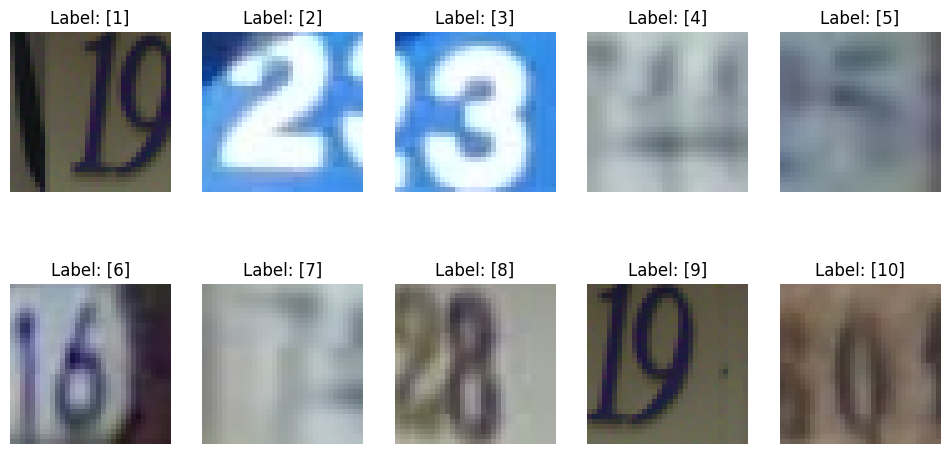

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i,idx in enumerate(indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[:,:,:,idx])
    ax.set_title(f'Label: {y_train[idx]}')
    ax.axis('off')

### Preprocessing

Для простоти задачі, будемо класифікувати цифри 0 та 1. Для тренування візьмемо 500 фото з 0 та 500 фото з 1. Для тестування візьмемо 100 фото з 0 та 100 фото з 1.

In [9]:
for i, label in enumerate(y_train):
    if label == 10:
        y_train[i][0] = 0

for i, label in enumerate(y_test):
    if label == 10:
        y_test[i][0] = 0

In [10]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [11]:
train_indices = np.concatenate([
    np.where(y_train == 0)[0][:100],
    np.where(y_train == 1)[0][:100]
])
test_indices = np.concatenate([
    np.where(y_test == 0)[0][:25],
    np.where(y_test == 1)[0][:25]
])

In [12]:
X_train = X_train[:,:,:,train_indices]
y_train = y_train[train_indices]
X_test  = X_test[:,:,:,test_indices]
y_test  = y_test[test_indices]

In [13]:
X_train = X_train.reshape(img_height*img_width*num_channels, -1)
y_train = y_train.reshape(1,-1)
X_test  = X_test.reshape(img_height*img_width*num_channels, -1)
y_test  = y_test.reshape(1,-1)

### Neural Network

In [14]:
class DeepNeuralNetwork:
    def __init__(self, layers_dims, activation_function="relu"):
        self.layers_dims = layers_dims
        self.activation_function = activation_function
        self.parameters = self.initialize_parameters_deep(layers_dims)

    def sigmoid(self, Z):
        A = 1/(1+np.exp(-Z))
        cache = Z

        return A, cache

    def relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z
        return A, cache

    def tanh(self, Z):
        A = np.tanh(Z)
        cache = Z
        return A, cache

    def relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def tanh_backward(self, dA, cache):
        Z = cache
        dZ = dA * (1 - np.tanh(Z)**2)
        return dZ

    def sigmoid_backward(self, dA, cache):
        Z = cache

        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)

        assert (dZ.shape == Z.shape)

        return dZ

    def initialize_parameters_deep(self, layer_dims):
        np.random.seed(1)
        parameters = {}
        L = len(layer_dims)
        for l in range(1, L):
            parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
            parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
        return parameters

    def linear_forward(self, A, W, b):
        Z = W.dot(A) + b
        cache = (A, W, b)
        return Z, cache

    def linear_activation_forward(self, A_prev, W, b, activation):
        Z, linear_cache = self.linear_forward(A_prev, W, b)

        if activation == "sigmoid":
            A, activation_cache = self.sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.tanh(Z)
        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        cache = (linear_cache, activation_cache)
        return A, cache

    def L_model_forward(self, X):
        caches = []
        A = X
        L = len(self.parameters) // 2
        for l in range(1, L):
            A_prev = A
            A, cache = self.linear_activation_forward(
                A_prev,
                self.parameters[f'W{l}'],
                self.parameters[f'b{l}'],
                activation=self.activation_function
            )
            caches.append(cache)
        AL, cache = self.linear_activation_forward(
            A,
            self.parameters[f'W{L}'],
            self.parameters[f'b{L}'],
            activation="sigmoid"
        )
        caches.append(cache)

        assert(AL.shape == (1,X.shape[1]))
        return AL, caches

    def compute_cost(self, AL, Y):
        m = Y.shape[1]
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
        cost = np.squeeze(cost)
        return cost

    def linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = 1./m * np.dot(dZ, A_prev.T)
        db = 1./m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)

        return dA_prev, dW, db

    def linear_activation_backward(self, dA, cache, activation):
        linear_cache, activation_cache = cache

        if activation == "relu":
            dZ = self.relu_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        elif activation == "tanh":
            dZ = self.tanh_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        elif activation == "sigmoid":
            dZ = self.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

        return dA_prev, dW, db

    def L_model_backward(self, AL, Y, caches):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        current_cache = caches[L-1]
        grads[f"dA{L-1}"], grads[f"dW{L}"], grads[f"db{L}"] = self.linear_activation_backward(dAL, current_cache, activation="sigmoid")
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(
                grads[f"dA{l+1}"],
                current_cache,
                activation=self.activation_function
            )
            grads[f"dA{l}"] = dA_prev_temp
            grads[f"dW{l+1}"] = dW_temp
            grads[f"db{l+1}"] = db_temp
        return grads

    def update_parameters(self, grads, learning_rate):
        L = len(self.parameters) // 2
        for l in range(L):
            self.parameters[f"W{l+1}"] = self.parameters[f"W{l+1}"] - learning_rate * grads[f"dW{l+1}"]
            self.parameters[f"b{l+1}"] = self.parameters[f"b{l+1}"] - learning_rate * grads[f"db{l+1}"]
        return self.parameters

    def fit(self, X, Y, learning_rate=0.0075, num_iterations=3000, print_cost=False):
        costs = []
        for i in range(num_iterations):

            AL, caches = self.L_model_forward(X)
            cost = self.compute_cost(AL, Y)
            grads = self.L_model_backward(AL, Y, caches)
            self.parameters = self.update_parameters(grads, learning_rate)
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" % (i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
        return costs

    def predict(self, X, y):
        m = X.shape[1]
        n = len(self.parameters)
        p = np.zeros((1,m))

        probas, caches = self.L_model_forward(X)


        for i in range(0, probas.shape[1]):
            if probas[0,i] >= 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0

        #print results
        # print ("predictions: " + str(probas))
        #print ("true labels: " + str(y))
        print("Accuracy: "  + str(np.sum((p == y)/m)))

        return p



### Тестування

#### DNN tanh learning_rate=0.0075

In [15]:
layers_dims = [img_height*img_width*num_channels, 10,7, 1]
learning_rate = 0.0075

dnn_tanh = DeepNeuralNetwork(
    layers_dims=layers_dims,
    activation_function="tanh"
)



In [16]:
%%time
costs= dnn_tanh.fit(
    X_train,
    y_train,
    num_iterations=3000,
    learning_rate=learning_rate,
    print_cost=True
)


Cost after iteration 0: 0.706542
Cost after iteration 100: 0.629621
Cost after iteration 200: 0.584283
Cost after iteration 300: 0.553660
Cost after iteration 400: 0.530200
Cost after iteration 500: 0.510084
Cost after iteration 600: 0.491533
Cost after iteration 700: 0.473483
Cost after iteration 800: 0.455339
Cost after iteration 900: 0.436788
Cost after iteration 1000: 0.416948
Cost after iteration 1100: 0.395846
Cost after iteration 1200: 0.375327
Cost after iteration 1300: 0.356418
Cost after iteration 1400: 0.339229
Cost after iteration 1500: 0.323514
Cost after iteration 1600: 0.308952
Cost after iteration 1700: 0.295235
Cost after iteration 1800: 0.282055
Cost after iteration 1900: 0.269081
Cost after iteration 2000: 0.255977
Cost after iteration 2100: 0.242392
Cost after iteration 2200: 0.227982
Cost after iteration 2300: 0.212944
Cost after iteration 2400: 0.198422
Cost after iteration 2500: 0.184803
Cost after iteration 2600: 0.171211
Cost after iteration 2700: 0.154614
Cost

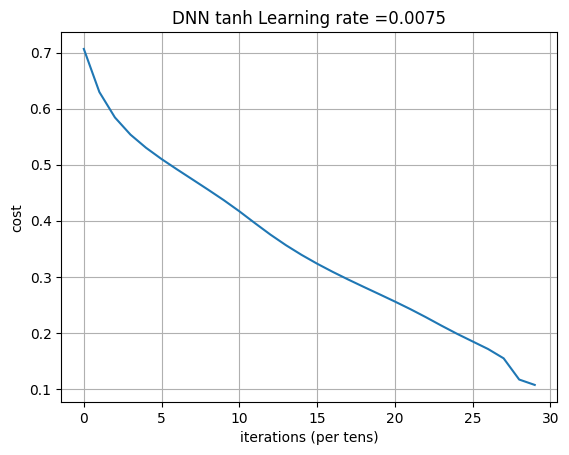

In [17]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("DNN tanh Learning rate =" + str(learning_rate))
plt.grid(True)
plt.show()

In [18]:
predict = dnn_tanh.predict(
    X_train,
    y_train
)

Accuracy: 0.9949999999999999


In [19]:
predict = dnn_tanh.predict(
    X_test,
    y_test
)

Accuracy: 0.72


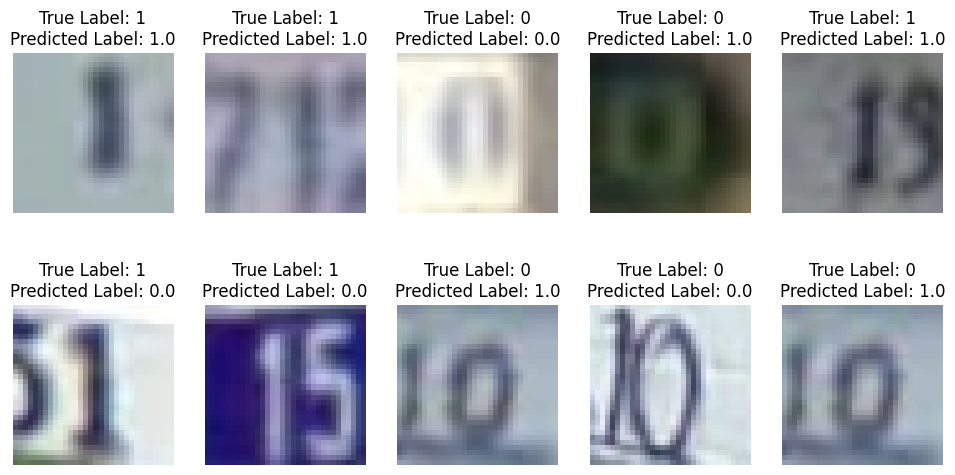

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # змінив 8 на 10

idx = np.random.randint(0, 50, 10)

for i, idx in enumerate(idx):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_test[:, idx].reshape(img_height, img_width, num_channels))
    title = f'True Label: {y_test[0, idx]}' + '\n'
    title += f'Predicted Label: {predict[0, idx]}'
    ax.set_title(title)
    ax.axis('off')


#### DNN relu learning_rate=0.0075

In [21]:
layers_dims = [img_height*img_width*num_channels, 10,7, 1]
learning_rate = 0.0075

dnn_relu = DeepNeuralNetwork(
    layers_dims=layers_dims,
    activation_function="relu"
)



In [22]:
%%time
costs= dnn_relu.fit(
    X_train,
    y_train,
    num_iterations=3000,
    learning_rate=learning_rate,
    print_cost=True
)


Cost after iteration 0: 0.696659
Cost after iteration 100: 0.663788
Cost after iteration 200: 0.642182
Cost after iteration 300: 0.618011
Cost after iteration 400: 0.588890
Cost after iteration 500: 0.553412
Cost after iteration 600: 0.514952
Cost after iteration 700: 0.472354
Cost after iteration 800: 0.425301
Cost after iteration 900: 0.383808
Cost after iteration 1000: 0.355753
Cost after iteration 1100: 0.329459
Cost after iteration 1200: 0.302467
Cost after iteration 1300: 0.272467
Cost after iteration 1400: 0.245210
Cost after iteration 1500: 0.238936
Cost after iteration 1600: 0.214157
Cost after iteration 1700: 0.235405
Cost after iteration 1800: 0.155092
Cost after iteration 1900: 0.159485
Cost after iteration 2000: 0.126137
Cost after iteration 2100: 0.287979
Cost after iteration 2200: 0.110600
Cost after iteration 2300: 0.114504
Cost after iteration 2400: 0.085362
Cost after iteration 2500: 0.656455
Cost after iteration 2600: 0.073195
Cost after iteration 2700: 0.066002
Cost

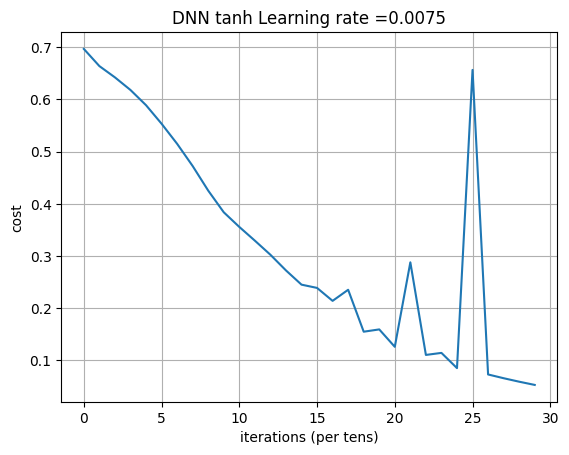

In [23]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("DNN tanh Learning rate =" + str(learning_rate))
plt.grid(True)
plt.show()

In [24]:
predict = dnn_relu.predict(
    X_train,
    y_train
)

Accuracy: 0.9999999999999998


In [25]:
predict = dnn_relu.predict(
    X_test,
    y_test
)

Accuracy: 0.8600000000000001


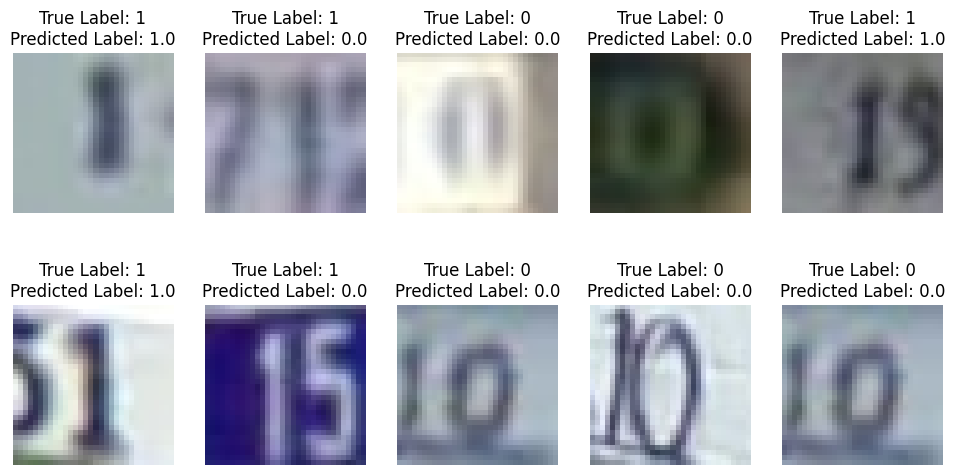

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # змінив 8 на 10

idx = np.random.randint(0, 50, 10)

for i, idx in enumerate(idx):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_test[:, idx].reshape(img_height, img_width, num_channels))
    title = f'True Label: {y_test[0, idx]}' + '\n'
    title += f'Predicted Label: {predict[0, idx]}'
    ax.set_title(title)
    ax.axis('off')


## Висновки

Було реалізовано нейромережу зворотнього розповсюдження. Для оптимізації часу навчання було обрано меншу кількість класів та прикладів кожного класу з вибірки для навчання DNN.

Оскільки при великих значення `learning_rate` функція втрат може значно коливатися, а при маленьких - довго збігатися, то було обрано оптимальне `learning_rate=0.0075`.

Побудовано два DNN з різними функціями активаціями прихованих шарів - relu та tanh. DNN tanh виявилася трохи точнішою, проте крива функції втрат дуже хаотична, у порівнянні з кривою функції втрат DNN relu.